<a href="https://colab.research.google.com/github/krislars/DustTools/blob/main/Fitting_isochrones_with_emcee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting Isochrones with Emcee: A Demonstration

Kristen Larson \\
krislars@gmail.com

This notebook shows how to use Monte Carlo Markov Chains (MCMC) as implemented by ``emcee`` to fit observed star cluster photometry with unknown extinction to a stellar isochrone.  Note that downloading the isochrones takes several minutes the first time the notebook is run.

## Installs and imports

In [1]:
!pip install dust_extinction # provides the extinction law shape
from dust_extinction.parameter_averages import F19
!pip install speclite # provides filter transmission curves
import speclite.filters
!pip install isochrones # provides stellar models
from isochrones.mist import MIST_Isochrone

In [2]:
# from google.colab import drive
import numpy as np
from matplotlib import pyplot as plt
# import astropy.units as u
# from astropy.coordinates import SkyCoord
# from astropy.io import ascii,fits
# from astropy.table import Table,MaskedColumn
import emcee
import corner

## Get models and build simulated data

First, choose your cluster parameters: distance, age, metallicity, and foreground extinction.  We will generate simulated data based on this known solution to check that the fitting procedure works.

In [3]:
dist_dat = 10. # 10 kpc
age_dat = 10. # log10(age in yr), 10 Gyr
met_dat = -1.0 # metallicity Fe/H
ext_dat = 0.5 # A_V magnitudes

Next, choose which photometric bands you want and get the set of isochrones in those bands.

In [4]:
band1 = 'g'
band2 = 'r'

In [5]:
# magnitudes are in the form filter_mag
mist = MIST_Isochrone(["DECam_u", "DECam_g", "DECam_r", "DECam_i", "DECam_z", "DECam_Y"])

This first time the isochrones are used in a notebook, Colab has to download them.  Be patient, as it might take several minutes.  Here we plot a few of them to trigger that download.

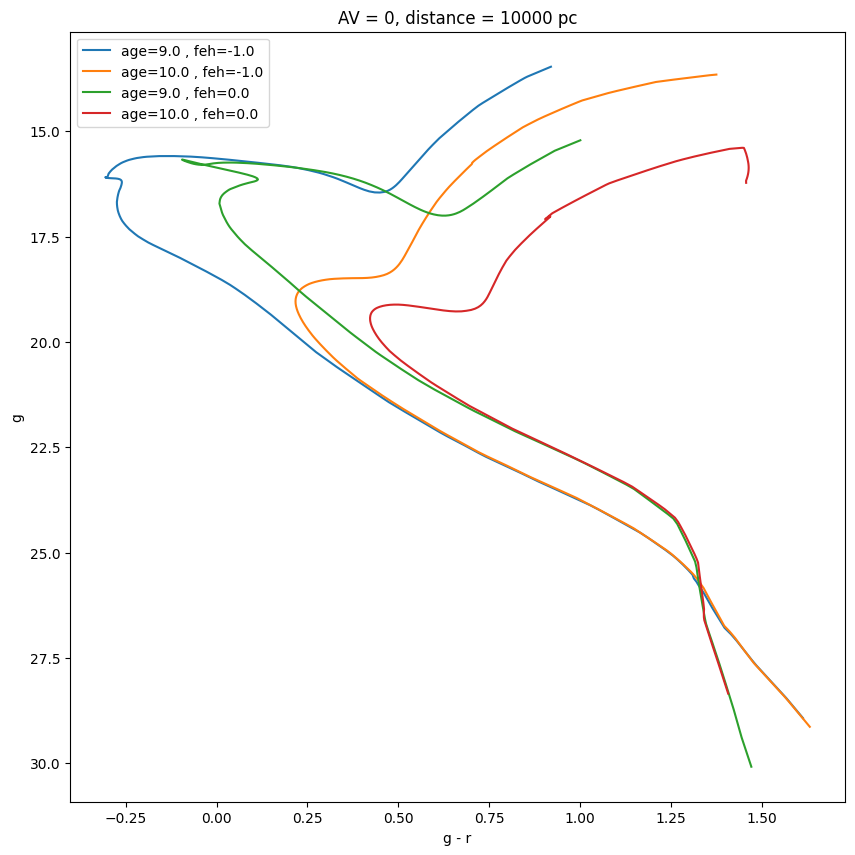

In [6]:
fig,ax=plt.subplots(1,1,figsize=(10,10))

for feh in [-1.0,0.0]:
    for age in [9.0,10.0]:
        isoch = mist.isochrone(age, feh, distance=10000, AV=0, eep_range=(200,600))
        ax.plot(isoch['DECam_'+band1+'_mag']-isoch['DECam_'+band2+'_mag'],isoch['DECam_'+band1+'_mag'],
                 label='age='+str(age)+' , feh='+str(feh))

fig.gca().invert_yaxis()
plt.xlabel(band1+' - '+band2)
plt.ylabel(band1)
ax.legend()
ax.set_title('AV = 0, distance = 10000 pc')
fig.show()

Next, let's make fake data to fit.  We'll start with the isochrone and add some uncertainties.  Note that we add the foreground extinction in a later step.

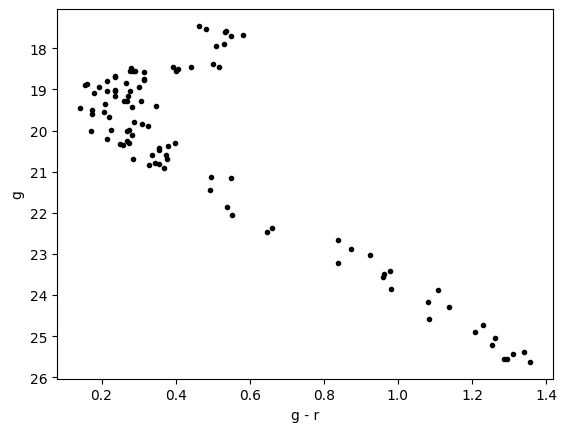

In [7]:
isoch = mist.isochrone(age_dat, met_dat, distance=dist_dat*1000., AV=0, eep_range=(200,500))
dat1 =isoch['DECam_'+band1+'_mag'][50:].values
dat2 =isoch['DECam_'+band2+'_mag'][50:].values

np.random.seed(42) # pseudo-random numbers for reproducibility
choose = np.random.choice(len(dat1),100,replace=False) # random stars on isochrone
datmag = dat1[choose] + np.random.normal(loc=0.0, scale=0.05, size=len(choose))
datcol = dat1[choose] - dat2[choose] + np.random.normal(loc=0.0, scale=0.05, size=len(choose))
errmag = np.zeros(len(choose)) + 0.1
errcol = np.zeros(len(choose)) + 0.1

plt.plot(datcol, datmag, 'k.')
plt.gca().invert_yaxis()
plt.xlabel(band1+' - '+band2)
plt.ylabel(band1)
plt.show()

*Future improvement:  Choose stars weighted by initial mass function and observational limits.*

Next, initialize extinction curve.  Here we'll make the assumption that the extinction curve changes slow enough in the bandpass that we can use the extinction curve as a lookup table with the effective wavelength.

In [8]:
extcurve = F19(Rv=3.1)
decam = speclite.filters.load_filters('decam2014-*')
bands = ['u','g','r','i','z','Y']
leff = dict(zip(bands, decam.effective_wavelengths))
A1AV = extcurve(leff[band1])
A2AV = extcurve(leff[band2])
print(A1AV,A2AV)

1.1815186865332903 0.8326270892160166


Apply the chosen foreground extinction to the simulated data.  There are lots of opportunities to add uncertainty here!

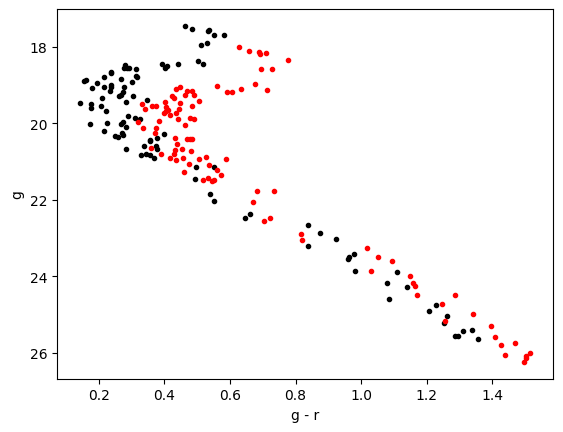

In [9]:
# Now add NN mag extinction with random distribution width MM
aloc=ext_dat
ascale=0.1*ext_dat
fakeAV = np.random.normal(loc=aloc, scale=ascale, size=len(datmag))
datmag_ext = datmag + fakeAV*A1AV
datcol_ext = datcol + fakeAV*(A1AV - A2AV)
avmax = fakeAV.max()

plt.plot(datcol, datmag, 'k.')
plt.plot(datcol_ext, datmag_ext, 'r.')
plt.gca().invert_yaxis()
plt.xlabel(band1+' - '+band2)
plt.ylabel(band1)
plt.show()

Extinction and reddening moves the data down and to the right, respectively.

## Run ``emcee``

Here is the heart of the matter!  Here is where we definte the log likelihood.  There are several things to notice here.

First, notice that we still have to define a goodness-of-fit metric by which likelihood is measured.  In other words, if we use the metric of gaussian-error-weighted RMS deviation between data and model (i.e. chi-squared), then we should get results similar to any linear optimization routine.  It is our ability to define other metrics within the log likelihood that makes this method so powerful.

Second, notice that even with this metric, the log likelihood includes other terms that are usually ignored in linear optimization. The reason is that in a chi-squared minimization simply minimizes a landscape no matter what the value of the landscape is.  In MCMC, the walkers decide whether to move based on a probability that depends on the actual value of the landscape is.  These terms matter.  See the Appendix at the end of the notebook for a derivation.

Third, here is where the speed of calculations can make a big difference between waiting a few minutes and waiting for days!  Any loop in this function will slow things down considerably.  Use numpy's matrix math instead.

In [10]:
def log_likelihood(theta, datcol, datmag, errcol, errmag):
    a, m, d, av = theta
    isoch = mist.isochrone(a, m, distance=d*1000.0, eep_range=(200,600))
    isocol=isoch['DECam_'+band1+'_mag']-isoch['DECam_'+band2+'_mag']
    isomag=isoch['DECam_'+band1+'_mag']
    nodustmag = datmag - av*A1AV
    nodustcol = datcol - av*(A1AV - A2AV)
    deltamag = np.broadcast_to(nodustmag,(len(isomag),len(nodustmag))) - np.transpose(np.broadcast_to(isomag,(len(nodustmag),len(isomag))))
    deltacol = np.broadcast_to(nodustcol,(len(isocol),len(nodustcol))) - np.transpose(np.broadcast_to(isocol,(len(nodustcol),len(isocol))))
    metric2 = np.amin((deltamag/errmag)**2 + (deltacol/errcol)**2,axis=0)
    return -0.5 * np.sum(metric2) - np.sum(np.log(errcol) + np.log(errmag)) - 1.84*len(metric2)

We will use a flat prior, truncating the search space.

In [11]:
def log_prior(theta):
    a, m, d, av = theta
    # hard limit on age: 10.29
    if 9.75 < a < 10.25 and -2.0 < m < 0.0 and 5 < d < 15 and -0.5 < av < 1.5:
        return 0.0
    return -np.inf

Remember, probability is multiplicative so log probability is additive.

In [12]:
def log_probability(theta, datcol, datmag, errcol, errmag):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, datcol, datmag, errcol, errmag)

Our first guess will be just a bit off the correct answer to show the demonstration without many steps.

In [13]:
start_guess = np.array([10.1,-1.1,10.1,0.0])

pos = start_guess + 1e-4 * np.random.randn(32, 4) # orig: 32 walkers
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(datcol_ext, datmag_ext, errcol, errmag)
)

In [14]:
sampler.run_mcmc(pos, 1000, progress=True);

100%|██████████| 1000/1000 [03:12<00:00,  5.19it/s]


Let's plot the walkers to check for the burn-in time and make sure nothing weird happened.

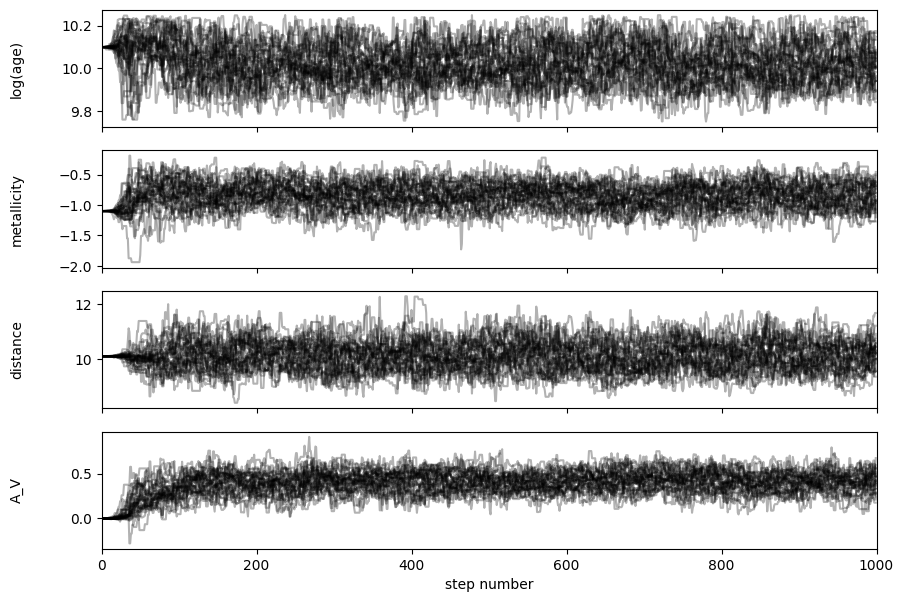

In [15]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["log(age)", "metallicity", "distance", "A_V"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [16]:
# Use this to help figure out how much burn-in time to discard
# tau = sampler.get_autocorr_time()
# print(tau)

In [17]:
# Thin by half the autocorrelation time
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)
print(flat_samples.shape)

(1440, 4)


In [18]:
from IPython.display import Math

end_median=np.zeros(4)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    end_median[i] = mcmc[1]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The optimization found the values we chose when we created the simulated data.  The distribution of walkers gives us an important measure of the uncertainty in each parameter, and corner plots are a powerful way to show that.  Green lines are the median walker values and blue lines are the values set when we generated the data.

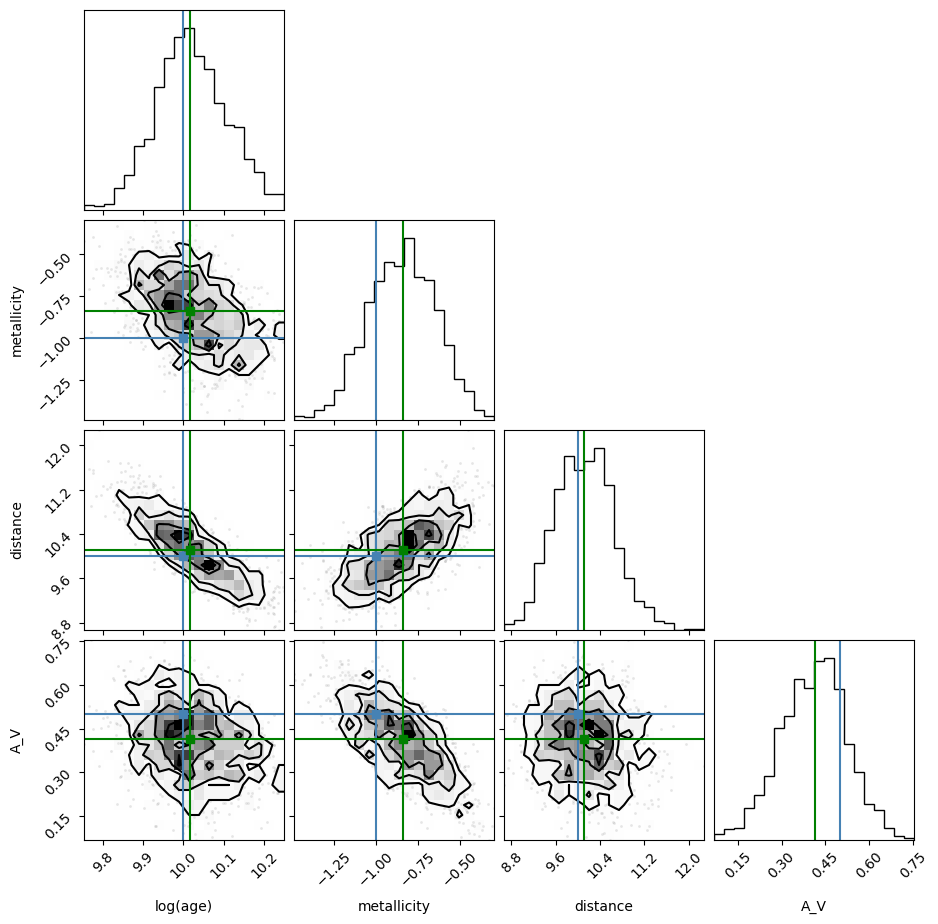

In [19]:
init_values = np.array([age_dat,met_dat,dist_dat,ext_dat])
fig = corner.corner(flat_samples, labels=labels, truths=init_values);
corner.overplot_lines(fig, end_median, color="green")
corner.overplot_points(fig, end_median[None], marker="s", color="green")

Notice the strong correlation between some parameters.  The extinction was not found exactly because we added variable uncertainty to stars in the cluster.  Metallicity is not well constrained because of the degeneracy with distance and extinction.

Finally we can plot the results.

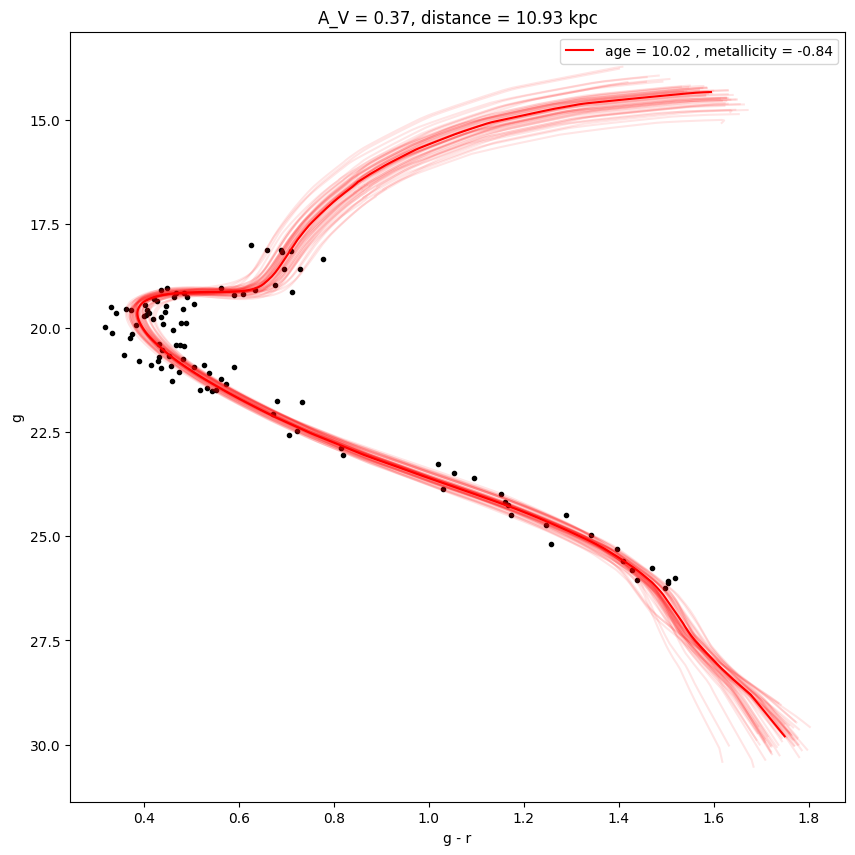

In [20]:
fig,ax=plt.subplots(1,1,figsize=(10,10))

plt.plot(datcol_ext,datmag_ext,'k.')

age, feh, distance, av = end_median

isoch = mist.isochrone(age, feh, distance=distance*1000., AV=max(0,av), eep_range=(200,600))
ax.plot(isoch['DECam_'+band1+'_mag']-isoch['DECam_'+band2+'_mag'],isoch['DECam_'+band1+'_mag'],
            label='age = '+str(round(age,2))+' , metallicity = '+str(round(feh,2)),color='red')
inds = np.random.randint(len(flat_samples), size=50)
for ind in inds:
    sample = flat_samples[ind]
    age, feh, distance, av = sample
    isoch = mist.isochrone(age, feh, distance=distance*1000., AV=max(0,av), eep_range=(200,600))
    ax.plot(isoch['DECam_'+band1+'_mag']-isoch['DECam_'+band2+'_mag'],isoch['DECam_'+band1+'_mag'],
            color='red',alpha=0.1)


ax.set_title('A_V = '+str(round(av,2))+', distance = '+str(round(distance,2))+' kpc')
fig.gca().invert_yaxis()
plt.xlabel(band1+' - '+band2)
plt.ylabel(band1)
ax.legend()
fig.show()

The advantages of using MCMC here include the ability to sample the walkers to show the range of fits above.  

## Appendix: Derivation of log likelihood

The Gaussian distribution is essentially a statement of probability of obtaining a measurement.  For a two-dimensional fit, the probabilities are multiplied.  To minimize the 2D distance between the photometry and the isochrone, the probability is

$$
p_i = \frac{1}{2\pi\sigma_{xi}\sigma_{yi}}\exp \left( -\frac{(x_i - mx_i)^2}{2\sigma_{xi}^2} - \frac{(y_i - my_i)^2}{2\sigma_{yi}^2} \right)
$$
where $x,y$ are data and $mx,my$ are coordinates of the the closest isochrone point.  Notice those factors out front that normalize the distributions to probabilities.  These are the factors that are often ignored in chi-squared minimizations.

Likelihood means
$$
\begin{align}
\mathcal{L} & = \prod^N_i p_i \\
  & =  \prod^N_i \frac{1}{2\pi\sigma_{xi}\sigma_{yi}}\exp \left(-\frac{(x_i - mx_i)^2}{2\sigma_{xi}^2} \right) \exp \left(- \frac{(y_i - my_i)^2}{2\sigma_{yi}^2} \right).
\end{align}
$$
Taking the log of each side, log likelihood is
$$
\begin{align}
\ln\mathcal{L} & = \sum_i^N \ln \frac{1}{2\pi\sigma_{xi}\sigma_{yi}} - \frac{1}{2}\sum_i^N \left( \frac{(x_i - mx_i)^2}{\sigma_{xi}^2} +  \frac{(y_i - my_i)^2}{\sigma_{yi}^2} \right) \\
& = - \sum_i^N (\ln 2\pi + \ln \sigma_{xi} + \ln \sigma_{yi}) - \frac{1}{2}\sum_i^N \left( \frac{(x_i - mx_i)^2}{\sigma_{xi}^2} +  \frac{(y_i - my_i)^2}{\sigma_{yi}^2} \right) \\
& = - N \ln 2\pi - \sum_i^N (\ln \sigma_{xi} + \ln \sigma_{yi}) - \frac{1}{2}\sum_i^N \left( \frac{(x_i - mx_i)^2}{\sigma_{xi}^2} +  \frac{(y_i - my_i)^2}{\sigma_{yi}^2} \right)
\end{align}
$$
which is
$$
\ln \mathcal{L} = - 1.84 N - \sum_i^N (\ln \sigma_{xi} + \ln \sigma_{yi}) - \frac{1}{2}\sum_i^N \left( \frac{(x_i - mx_i)^2}{\sigma_{xi}^2} +  \frac{(y_i - my_i)^2}{\sigma_{yi}^2} \right).
$$
The last term is the chi-squared terms.  The other two terms depend on the number of points and the size of the error bars.


## Further reading

[David Hogg, Jo Bovy, Dustin Lang (2010)](https://arxiv.org/abs/1008.4686) \\
[emcee docs by Dan Foreman-Mackey](https://emcee.readthedocs.io/en/stable/tutorials/line/)